In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer  #유방암 데이터 호출
from sklearn.model_selection import train_test_split  # 데이터를 분리하기위한 test_split

cancer = load_breast_cancer()  # cancer변수에 유방암데이터 선언
x = cancer.data                # x는 유방암데이터의 데이터값
y = cancer.target              # y는 유방암데이터의 타겟값

x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)
# 타겟 데이터를 고르게 분포 (stratify = y)
# test_size는 데이터 세트의 비율을 조절할떄 사용
# random_state는 무작위로 데이터를 섞은 다음 나누기 위해 사용

# x(569,30) 개의 데이터를 x_train_all(455,30) 과 x_test(114,30) 으로 분리한다.
# y(569, ) 개의 타겟을 y_train_all(455, ) 와 y_test(114, )로 분리한다.

x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)
#x_train_all(455,30)을 x_train(364,30)과 x_val(91,30)으로 분리한다 train은 훈련데이터 val은 검증데이터
#y_train_all(455, )를 y_train(364, )와 y_val(91, )로 분리한다 

In [2]:
#데이터 크기확인
print(x_train.shape, x_val.shape)



(364, 30) (91, 30)


In [3]:
class SingleLayer:

    def __init__(self, learning_rate=0.1, l1=0, l2=0):  #learning_rate 는 학습률 
        self.w = None #가중치
        self.b = None #절편
        self.losses = []  #훈련 손실
        self.val_losses = [] #검증 손실
        self.w_history = [] #가중치 기록
        self.lr = learning_rate #학습률
        self.l1 = l1  #L1 손실 하이퍼 파라미터
        self.l2 = l2  #L2 손실 하이퍼 파라미터
    
    def forpass(self, x):             # 정방향 계산
        z = np.dot(x,self.w) + self.b # 선형 출력을 계산함 / 기존엔 np.sum(x * self.w ) + self.b 라고 사용함
        return z                     # np.sum() 행렬 연산 / np.dot() 행렬 곱셈

    def backprop(self, x, err):         # 역방향 계산
        m = len(x)                      # m은 x_train의 길이 (364)
        w_grad = np.dot(x.T, err) / m   # 가중치에 대한 그레이디언트 계산 x.T는 X를 전치한값 (30,364)*(364,1)=(30,1)/ m(364)
        b_grad = np.sum(err) / m        # 절편에 대한 그레이디언트 계산
        return w_grad, b_grad
  
    def activation(self, z):
        a = 1 / (1 + np.exp(-z))       #시그모이드 계산 / exp함수는 각 성분을 무리수 e의 지수로 삼은 값을 계산함
        return a
  
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        y = y.reshape(-1, 1)  #타깃을 열 벡터로 바꿈
        y_val = y_val.reshape(-1, 1) #검증용 타깃을 열 벡터로 바꿈
        
        m = len(x)                    #샘플 갯수를 저장
        self.w = np.ones((x.shape[1], 1)) #가중치를 초기화함
        self.b = 0                      # 절편을 초기화함
        self.w_history.append(self.w.copy()) # 가중치 기록
        #epochs만큼 반복
        for i in range(epochs):
            z = self.forpass(x)             #정방향 계산을 수행
            a = self.activation(z)          #활성화 함수를 적용
            err = -(y - a)                  #오차를 계산합니다
            # 오차를 역전파 하여 그레이디언트를 계산
            w_grad, b_grad = self.backprop(x, err)
            #그레이디언트에서 페널티 항의 미분값을 뺍니다
            w_grad += (self.l1 * np.sign(self.w) + self.l2 * self.w) / m  #sign함수는 각 성분의 부호를 계산함 +인경우1 -인경우 -1 0은0
            #가중치와 절편을 업데이트 합니다
            self.w -= self.lr * w_grad
            self.b -= self.lr * b_grad
            #가중치를 기록함
            self.w_history.append(self.w.copy())
            #안전한 로그 계산을 위해 클리핑 합니다.
            a = np.clip(a, 1e-10, 1-1e-10)
            #로그 손실과 규제 손실을 더하여 리스트에 추가합니다.
            loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))
            self.losses.append((loss + self.reg_loss()) / m)
            #검증 세트에 대한 손실을 계산함
            self.update_val_loss(x_val, y_val)
  
    def predict(self, x):
        z = self.forpass(x)   #정방향 계산을 수행
        return z > 0          #스텝 함수를 적용

    def score(self, x, y):
        #예측과 타깃 열 벡터를 비교하여 True의 비율을 반환
        return np.mean(self.predict(x) == y.reshape(-1, 1))

    def reg_loss(self):
        #가중치에 대한 규제를 적용
        return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)

    def update_val_loss(self, x_val, y_val):
        z = self.forpass(x_val)                   #정방향 계산을 수행
        a = self.activation(z)                    #활성화 함수를 적용
        a = np.clip(a, 1e-10, 1-1e-10)            #출력값을 클리핑함
        #로그 손실과 규제 손실을 더하여 리스트에 추가합니다.
        val_loss = np.sum(-(y_val * np.log(a) + (1-y_val) * np.log(1-a)))
        self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))

In [4]:
#훈련데이터 표준화 전처리하기 두줄은 이미 위에서 import함
#import numpy as np
#import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [5]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)
#x_train_scaled 는 훈련 세트를 전처리하여 표준화를 적용
#x_val_scaled 는 검증 세트를 전처리하여 표준화 적용



In [6]:
single_layer = SingleLayer(l2=0.01)
single_layer.fit(x_train_scaled , y_train, x_val=x_val_scaled, y_val=y_val, epochs=10000)
single_layer.score(x_val_scaled, y_val)


0.978021978021978

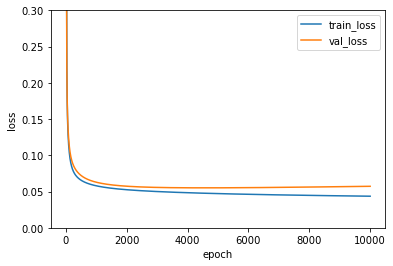

In [7]:
plt.ylim(0, 0.3)
plt.plot(single_layer.losses)
plt.plot(single_layer.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

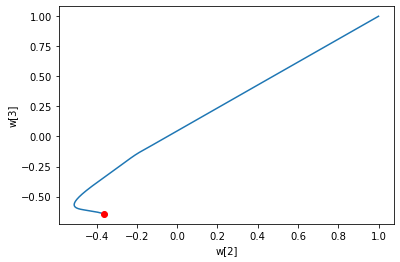

In [8]:
w2 = []
w3 = []
for w in single_layer.w_history:
    w2.append(w[2])
    w3.append(w[3])

plt.plot(w2,w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()

In [9]:
class DualLayer(SingleLayer):
    
    def __init__(self, units=10, learning_rate=0.1, l1=0, l2=0):
        self.units = units  #은닉층의 뉴런개수
        self.w1 = None  #은닉층의 가중치
        self.b1 = None  #은닉층의 절편
        self.w2 = None  #출력층의 가중치
        self.b2 = None  #출력층의 절편
        self.a1 = None  #은닉층의 활성화 출력
        self.losses = []  #훈련손실
        self.val_losses = []  #검증 손실
        self.lr = learning_rate  #학습률
        self.l1 = l1  #L1 손실 하이퍼파라미터
        self.l2 = l2  #L2 손실 하이퍼파라미터
    
    def forpass(self, x):
        z1 = np.dot(x, self.w1) + self.b1  #첫번째 층의 선형식 계산
        self.a1 = self.activation(z1)  #활성화 함수를 적용
        z2 = np.dot(self.a1, self.w2) + self.b2  #두번째 층의 선형식 계산
        return z2
    
    def backprop(self, x, err):
        m = len(x)  # 샘플 개수
        #출력층의 가중치와 절편에 대한 그레이디언트를 계산
        w2_grad = np.dot(self.a1.T, err) / m
        b2_grad = np.sum(err) / m
        #시그모이드 함수까지 그레이디언트를 계산함
        err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)
        #은닉층의 가중치와 절편에 대한 그레이디언트를 계산합니다.
        w1_grad = np.dot(x.T, err_to_hidden) / m
        b1_grad = np.sum(err_to_hidden, axis = 0) / m
        return w1_grad, b1_grad, w2_grad, b2_grad
    
    def init_weights(self, n_features):
        #ones()함수는 인자로 받는 크기만큼 모든 요소를 1로만듬
        #zeros()함수는 인자로 받는 크기만큼 모든 요소를 1로만듬
        self.w1 = np.ones((n_features, self.units))  #(특성개수, 은닉층의 크기)
        self.b1 = np.zeros(self.units)  #은닉층의 크기
        self.w2 = np.ones((self.units, 1))  #(은닉층의 크기, 1)
        self.b2 = 0
        
    def fit(self, x, y, epochs=100, x_val=None, y_val = None):
        y = y.reshape(-1, 1)  #타깃을 열 벡터로 바꿈.
        y_val = y_val.reshape(-1, 1)
        m = len(x)           #샘플 개수 저장
        self.init_weights(x.shape[1])   # 은닉층과 출력층의 가중치를 초기화
        # epochs 만큼 반복
        for i in range(epochs):
            a = self.training(x, y, m)
            # 안전한 로그 계산을 위해 클리핑
            a = np.clip(a, 1e-10, 1-1e-10)
            # 로그 손실과 규제 손실을 더하여 리스트에 추가함
            loss = np.sum(-(y*np.log(a) + (1-y) * np.log(1-a)))
            self.losses.append((loss + self.reg_loss()) / m)
            # 검증 세트에 대한 손실을 계산함
            self.update_val_loss(x_val, y_val)
            
    def training(self, x, y, m):
        z = self.forpass(x)   # 정방향 계산을 수행 함
        a = self.activation(z)  # 활성화 함수를 적용함
        err = -(y - a)
        # 오차를 역전파 하여 그레이디언트를 계산함
        w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
        # 그레이디언트에서 패널티 항의 미분값을 뺍니다.
        w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m  #sign()함수는 각 성분의 부호계산(+인경우 1 -인경우 -1 0은0)
        w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
        #은닉층의 가중치와 절편을 업데이트함
        self.w1 -= self.lr * w1_grad
        self.b1 -= self.lr * b1_grad
        #출력층의 가중치와 절편을 업데이트함
        self.w2 -= self.lr * w2_grad
        self.b2 -= self.lr * b2_grad
        return a
        
    def reg_loss(self):
        #은닉층의 출력층의 가중치에 규제를 적용함
        return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))
        

In [10]:
dual_layer = DualLayer(l2=0.01)
dual_layer.fit(x_train_scaled, y_train, x_val = x_val_scaled, y_val=y_val, epochs=20000)
dual_layer.score(x_val_scaled, y_val)

0.978021978021978

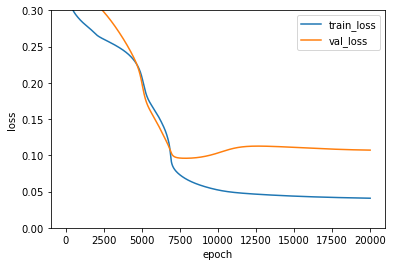

In [11]:
plt.ylim(0, 0.3)
plt.plot(dual_layer.losses)
plt.plot(dual_layer.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [12]:
class RandomInitNetwork(DualLayer):
    
    def init_weights(self, n_features):
        np.random.seed(42)
        self.w1 = np.random.normal(0, 1, (n_features, self.units)) #(특성 개수, 은닉층의 크기) #0은 평균 1은 표준편차
        self.b1 = np.zeros(self.units)  #은닉층의 크기
        self.w2 = np.random.normal(0, 1, (self.units, 1))   #(은닉층의 크기, 1)
        self.b2 = 0

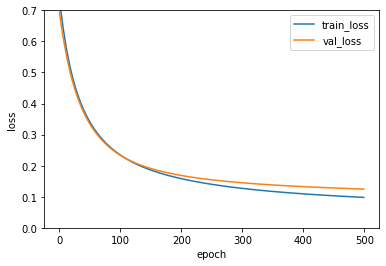

In [13]:
random_init_net = RandomInitNetwork(l2=0.01)
random_init_net.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=500)

plt.ylim(0, 0.7)
plt.plot(random_init_net.losses)
plt.plot(random_init_net.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [14]:
# 6-3 미니 배치를 사용하여 모델을 훈련하기
class MinibatchNetwork(RandomInitNetwork):
    
    def __init__(self, units=10, batch_size = 32 , learning_rate = 0.1, l1=0, l2=0):
        super().__init__(units, learning_rate, l1, l2)
        self.batch_size = batch_size  #배치 크기
    
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        y = y.reshape(-1, 1)   #타깃을 열 벡터로 변경
        self.init_weights(x.shape[1])  #은닉층과 출력층의 가중치를 초기화
        np.random.seed(42)
        #epochs만큼 반복
        for i in range(epochs):
            loss =0
            #제너레이터 함수에서 반환한 미니 배치를 순환
            for x_batch, y_batch in self.gen_batch(x,y):
                y_batch = y_batch.reshape(-1, 1)  #타깃을 열벡터로 변경
                y_val = y_val.reshape(-1, 1)   #교재에 없는코드
                m = len(x_batch)  #샘플 개수 저장
                a = self.training(x_batch, y_batch , m)
                # 안전한 로그 계산을 위해 클리핑함
                a = np.clip(a, 1e-10, 1-1e-10)
                # 로그 손실과 규제 손실을 더하여 리스트에 추가함
                loss += np.sum(-(y_batch * np.log(a) + (1-y_batch) * np.log(1-a)))
            self.losses.append((loss + self.reg_loss()) / len(x))
            # 검증 세트에 대한 손실을 계산함
            self.update_val_loss(x_val, y_val)
    
    # 미니배치 제너레이터 함수
    def gen_batch(self, x, y):
        length = len(x)
        bins = length // self.batch_size  #미니 배치횟수
        if length % self.batch_size:
            bins += 1     #나누어 떨어지지 않을때
        indexes = np.random.permutation(np.arange(len(x)))  #인덱스를 섞는다
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]   # batch_size만큼 슬라이싱하여 반환한다

In [15]:
minibatch_net = MinibatchNetwork(l2 = 0.01, batch_size = 32)
minibatch_net.fit(x_train_scaled, y_train, x_val = x_val_scaled, y_val = y_val, epochs=500)
minibatch_net.score(x_val_scaled, y_val)


0.978021978021978

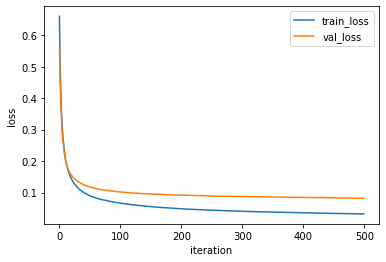

In [16]:
plt.plot(minibatch_net.losses)
plt.plot(minibatch_net.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [17]:
minibatch_net = MinibatchNetwork(l2 = 0.01, batch_size = 128)
minibatch_net.fit(x_train_scaled, y_train, x_val = x_val_scaled, y_val = y_val, epochs=500)
minibatch_net.score(x_val_scaled, y_val)


0.978021978021978

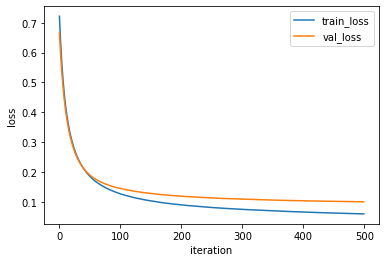

In [18]:
plt.plot(minibatch_net.losses)
plt.plot(minibatch_net.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [19]:
minibatch_net = MinibatchNetwork(l2 = 0.01, batch_size = 256)
minibatch_net.fit(x_train_scaled, y_train, x_val = x_val_scaled, y_val = y_val, epochs=500)
minibatch_net.score(x_val_scaled, y_val)

0.967032967032967

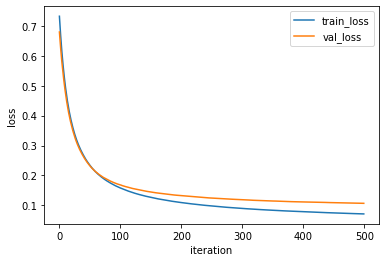

In [20]:
plt.plot(minibatch_net.losses)
plt.plot(minibatch_net.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()